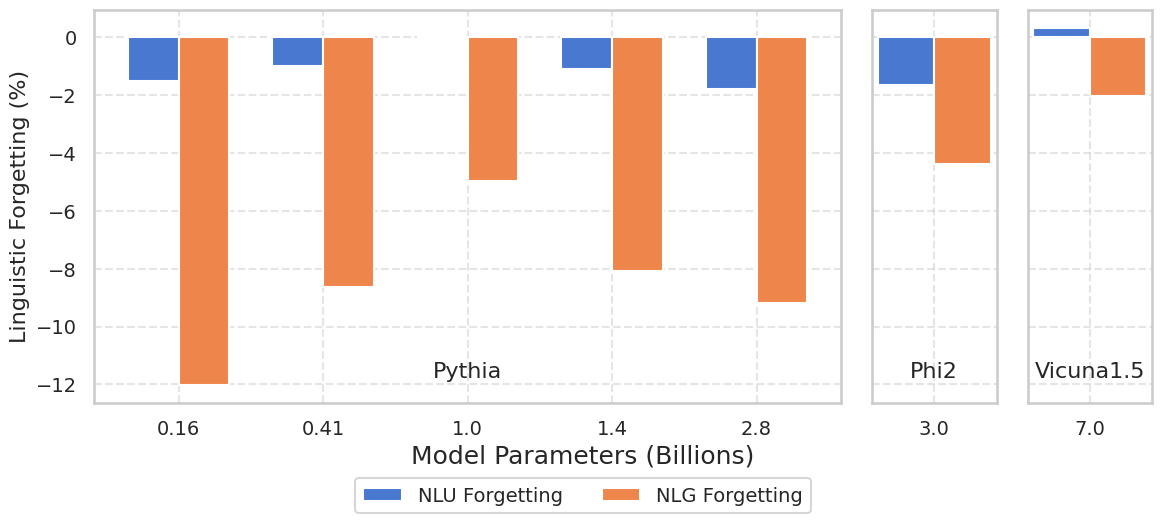

In [81]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [16, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [3, 0.5, 0.5]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, +0.08, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=16)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    # if i == 1:
    #     ax[i].set_xlabel('Model Parameters (Billions)', labelpad=20)

# Set the shared x-axis label
fig.text(0.5, 0.2, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()


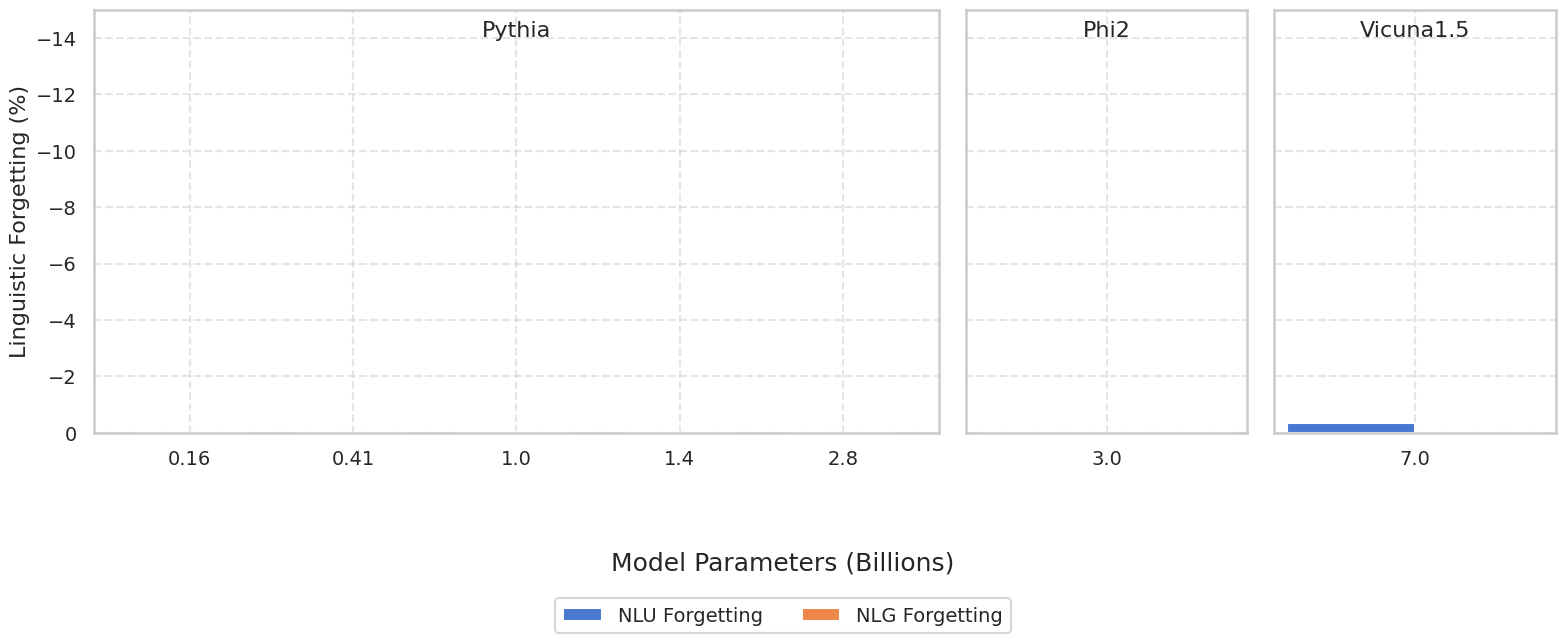

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [16, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, -avg_nlu_forgetting))  # Invert to negative values
                forgetting_scores[model_type]['nlg'].append((scale, -avg_nlg_forgetting))  # Invert to negative values
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1, 1]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, 0.95, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=16)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    ax[i].set_ylim(0, -15)  # Set the y-axis limits to negative values

# Set the shared x-axis label
fig.text(0.5, 0.02, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()

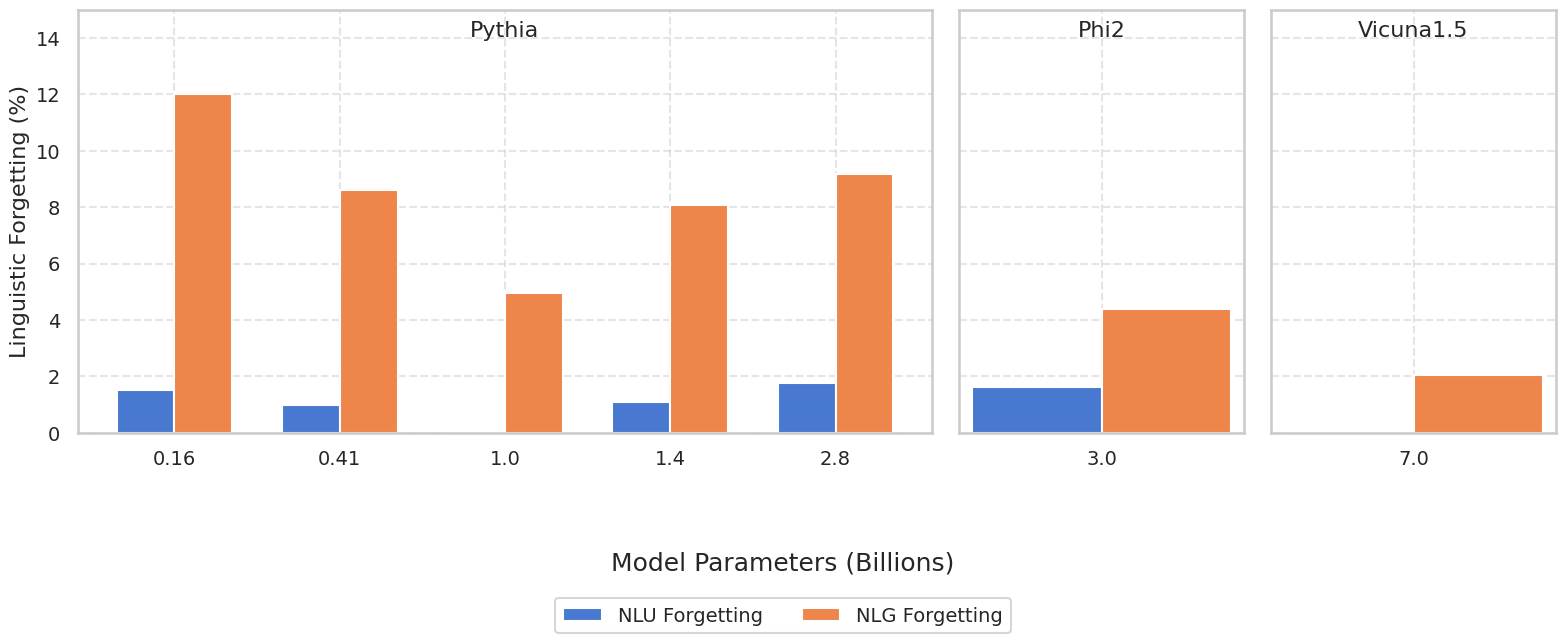

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [16, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))  # Keep original values
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))  # Keep original values
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Convert all values to positive for plotting
for model_type in forgetting_scores:
    forgetting_scores[model_type]['nlu'] = [(scale, -score) for scale, score in forgetting_scores[model_type]['nlu']]
    forgetting_scores[model_type]['nlg'] = [(scale, -score) for scale, score in forgetting_scores[model_type]['nlg']]

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1, 1]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, 0.95, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=16)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    ax[i].set_ylim(0, 15)  # Set the y-axis limits to positive values

# Set the shared x-axis label
fig.text(0.5, 0.02, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()

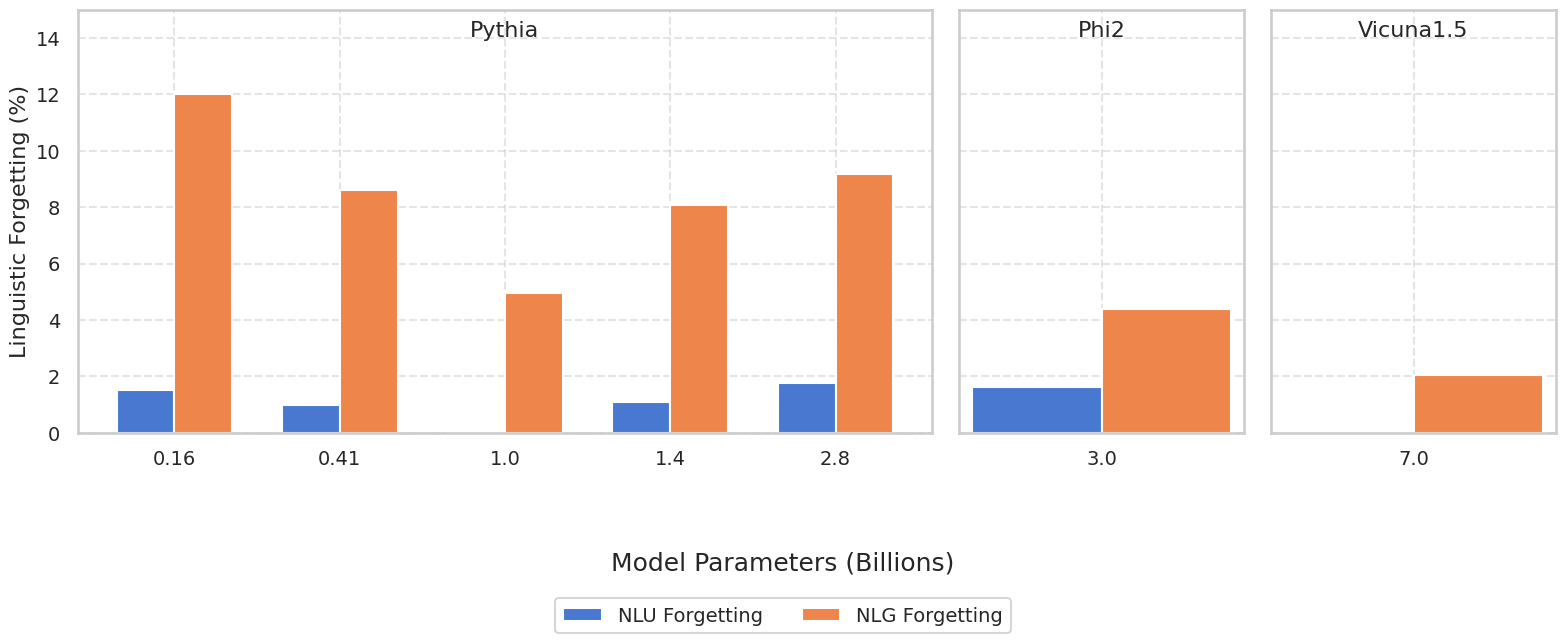

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [16, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))  # Keep original values
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))  # Keep original values
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Convert all values to positive for plotting
for model_type in forgetting_scores:
    forgetting_scores[model_type]['nlu'] = [(scale, max(0, -score)) for scale, score in forgetting_scores[model_type]['nlu']]
    forgetting_scores[model_type]['nlg'] = [(scale, max(0, -score)) for scale, score in forgetting_scores[model_type]['nlg']]

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1, 1]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, 0.95, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=16)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    ax[i].set_ylim(0, 15)  # Set the y-axis limits to positive values

# Set the shared x-axis label
fig.text(0.5, 0.02, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()

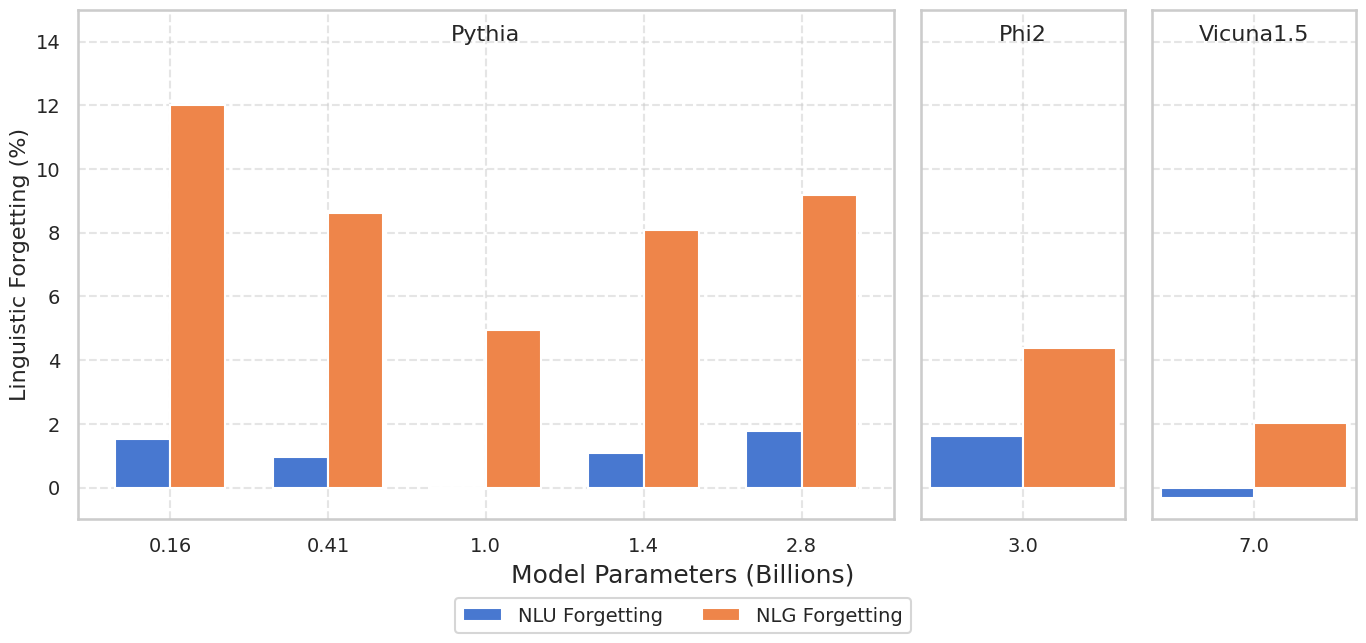

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [16, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))  # Keep original values
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))  # Keep original values
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Convert all values to positive for plotting
for model_type in forgetting_scores:
    forgetting_scores[model_type]['nlu'] = [(scale, -score) for scale, score in forgetting_scores[model_type]['nlu']]
    forgetting_scores[model_type]['nlg'] = [(scale, -score) for scale, score in forgetting_scores[model_type]['nlg']]

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True, gridspec_kw={'width_ratios': [4, 1, 1]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, 0.95, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=16)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    ax[i].set_ylim(-1, 15)  # Start y-axis from -1 to ensure values are visible

# Set the shared x-axis label
fig.text(0.5, 0.0, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
#plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()

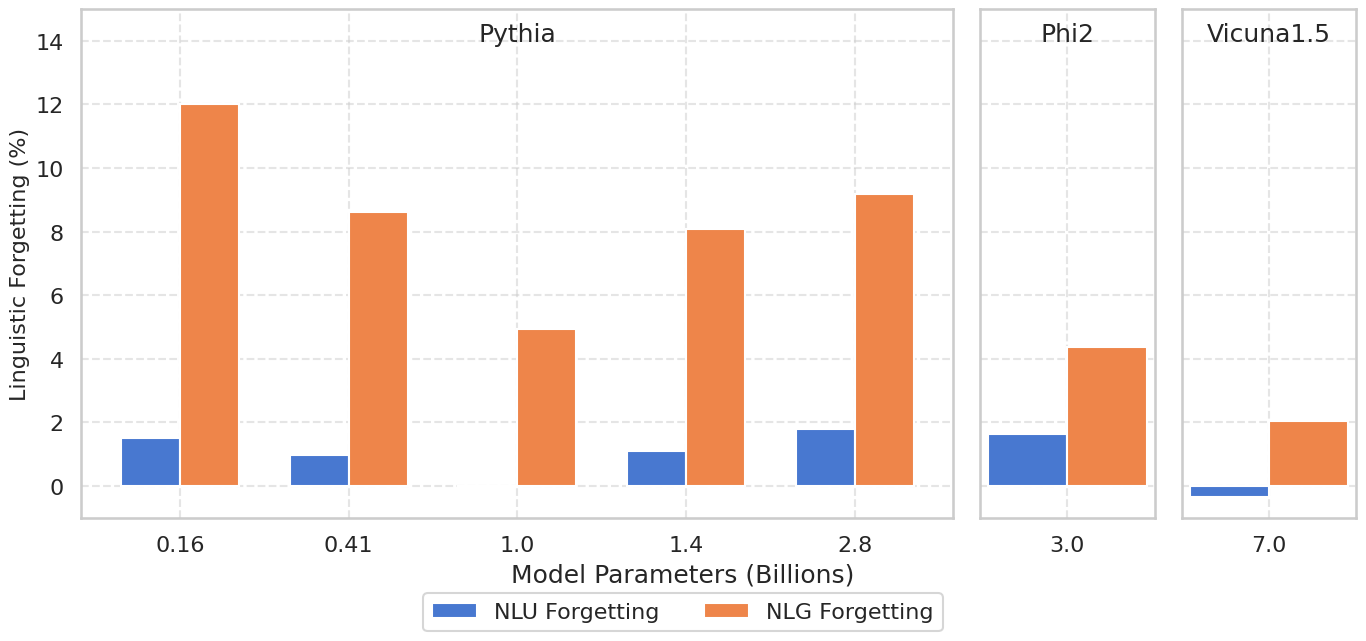

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [14, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))  # Keep original values
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))  # Keep original values
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Convert all values to positive for plotting
for model_type in forgetting_scores:
    forgetting_scores[model_type]['nlu'] = [(scale, -score if score != 0 else 0.1) for scale, score in forgetting_scores[model_type]['nlu']]
    forgetting_scores[model_type]['nlg'] = [(scale, -score if score != 0 else 0.1) for scale, score in forgetting_scores[model_type]['nlg']]

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True, gridspec_kw={'width_ratios': [5, 1, 1]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, 0.95, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=18)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    ax[i].set_ylim(-1, 15)  # Start y-axis from -1 to ensure values are visible

# Set the shared x-axis label
fig.text(0.5, 0.0, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
#plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()

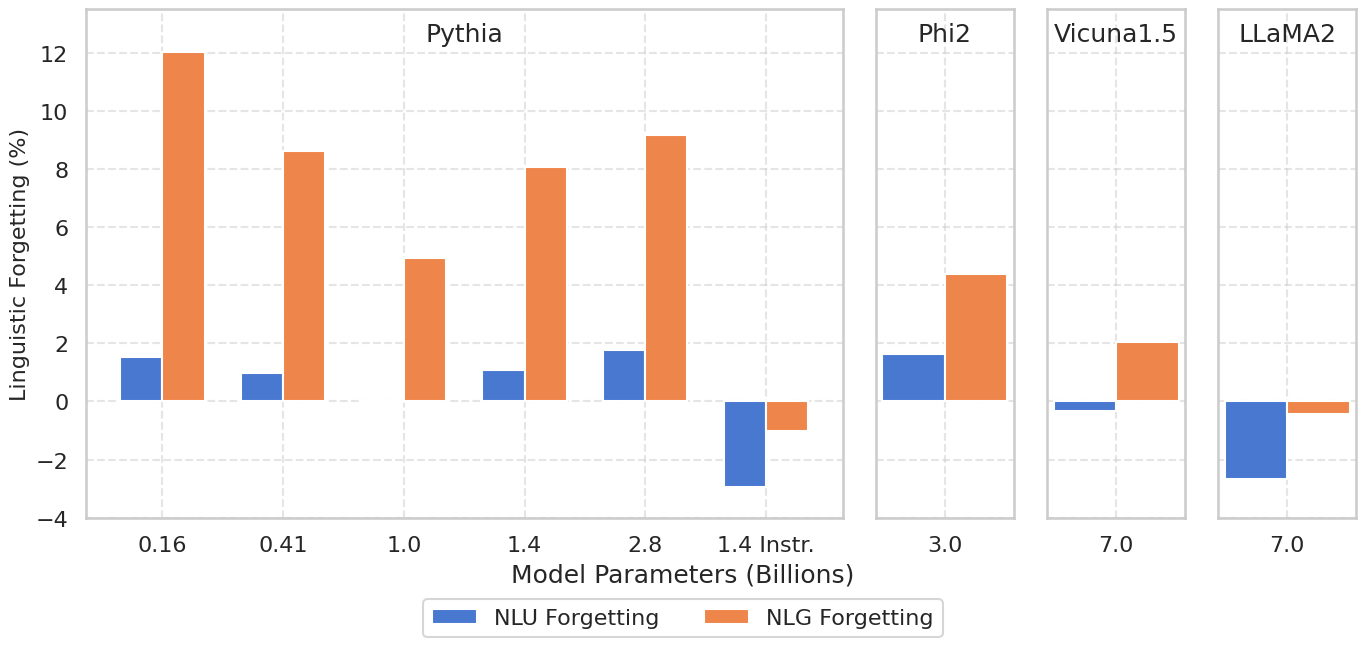

In [75]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [12, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b",
            '1.4-instruct': "stage-final-llava-v15-pythia+1p4b-instruct"  # Pythia 1.4B Instruct
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b",
            '1.4-instruct': "reproduction-align-pythia+1p4b-instruct"  # Pythia 1.4B Instruct
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    },
    'LLaMA2': {
        'llava_original': {
            '7b': "reproduction-llama2"
        },
        'base_llm': {
            '7b': "vila_base_llm"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))  # Keep original values
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))  # Keep original values
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0',
    '1.4-instruct': '1.4 Instr.'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5', 'LLaMA2','Pythia']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Convert all values to positive for plotting
for model_type in forgetting_scores:
    forgetting_scores[model_type]['nlu'] = [(scale, -score if score != 0 else 0.1) for scale, score in forgetting_scores[model_type]['nlu']]
    forgetting_scores[model_type]['nlg'] = [(scale, -score if score != 0 else 0.1) for scale, score in forgetting_scores[model_type]['nlg']]

# Plotting the bar charts
fig, ax = plt.subplots(1, 4, figsize=[14, 6], sharey=True, gridspec_kw={'width_ratios': [5.5, 1, 1, 1]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5', 'LLaMA2']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, 0.95, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=18)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    ax[i].set_ylim(-4, 13.5)  # Start y-axis from -1 to ensure values are visible

# Set the shared x-axis label
fig.text(0.5, 0.0, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, -0.11), ncol=2)

plt.tight_layout()
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()

In [77]:
forgetting_scores

{'Pythia': {'nlu': [(0.16, 1.5142969624141718),
   (0.41, 0.9706527590439524),
   (1.0, -0.033462677653561146),
   (1.4, 1.0924963618333783),
   (2.8, 1.776189920541081),
   ('1.4 Instr.', -2.9299044253176603)],
  'nlg': [(0.16, 12.012419949543956),
   (0.41, 8.616339996118766),
   (1.0, 4.948573646419563),
   (1.4, 8.072967203570736),
   (2.8, 9.17911895982923),
   ('1.4 Instr.', -1.009120900446342)]},
 'Phi2': {'nlu': [('3.0', 1.6255652265306635)],
  'nlg': [('3.0', 4.385794682709104)]},
 'Vicuna1.5': {'nlu': [('7.0', -0.342807849218954)],
  'nlg': [('7.0', 2.037647972055112)]},
 'LLaMA2': {'nlu': [('7.0', -2.665490511324709)],
  'nlg': [('7.0', -0.42693576557344404)]}}

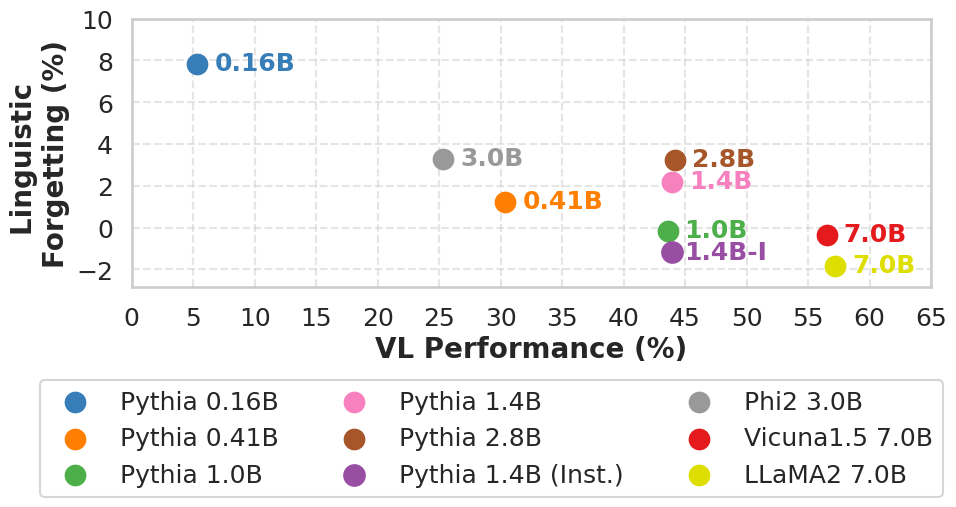

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

CB = ['#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
    '#999999', '#e41a1c', '#dede00']

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

plt.rcParams["figure.autolayout"] = True

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b",
            '1.4-instruct': "stage-final-llava-v15-pythia+1p4b-instruct"  # Pythia 1.4B Instruct
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b",
            '1.4-instruct': "reproduction-align-pythia+1p4b-instruct"  # Pythia 1.4B Instruct
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    },
    'LLaMA2': {
        'llava_original': {
            '7b': "reproduction-llama2"
        },
        'base_llm': {
            '7b': "vila_base_llm"
        }
    }
}

# Function to calculate NLP forgetting and VL performance using harmonic mean
def calculate_forgetting_and_performance(model_mappings, results):
    scores = []
    for model_type, mappings in model_mappings.items():
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                llava_nlp_scores = [results[llava_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
                base_nlp_scores = [results[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
                vl_scores = [results[llava_model].get(dataset, np.nan) * 100 for dataset in vl_datasets]
                
                valid_llava_nlp_scores = [score for score in llava_nlp_scores if not np.isnan(score)]
                valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
                valid_vl_scores = [score for score in vl_scores if not np.isnan(score)]
                
                if valid_llava_nlp_scores and valid_base_nlp_scores:
                    llava_hmean = hmean(valid_llava_nlp_scores)
                    base_hmean = hmean(valid_base_nlp_scores)
                    nlp_forgetting = base_hmean - llava_hmean
                else:
                    nlp_forgetting = np.nan
                
                avg_vl_performance = hmean(valid_vl_scores) if valid_vl_scores else np.nan
                
                scores.append((model_type, scale, nlp_forgetting, avg_vl_performance))
    return scores

# Calculate forgetting and performance for each model type
scores = calculate_forgetting_and_performance(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for i in range(len(scores)):
    model_type, scale, nlp_forgetting, vl_performance = scores[i]
    if model_type in ['Phi2', 'Vicuna1.5', 'LLaMA2']:
        scale = scale_rename.get(scale, scale)
    scores[i] = (model_type, scale, nlp_forgetting, vl_performance)

# # Convert all values to positive for plotting
# for i in range(len(scores)):
#     model_type, scale, nlp_forgetting, vl_performance = scores[i]
#     scores[i] = (model_type, scale, -nlp_forgetting, vl_performance)

# Plotting the scatter plot
#fig, ax = plt.subplots(figsize=(9, 5))
fig, ax = plt.subplots(figsize=(10, 6))

'''
for model_type, scale, nlp_forgetting, vl_performance in scores:
    ax.scatter(vl_performance, nlp_forgetting, label=f'{model_type} {scale}B', s=100)
    ax.text(vl_performance, nlp_forgetting, f'{scale}B', fontsize=12, ha='left')

ax.set_xlabel('VL Performance (%)')
ax.set_ylabel('Linguistic Forgetting (%)')
'''

m=20
p=18
i=0
for model_type, scale, nlp_forgetting, vl_performance in scores:

    if scale == '1.4-instruct':
        scale = '1.4'
        ax.scatter(vl_performance, nlp_forgetting, label=f'{model_type} {scale}B (Inst.)', s=220, color=CB[i])
        ax.text(vl_performance+7.7, nlp_forgetting-0.33, f'{scale}B-I', fontsize=p, ha='right', color=CB[i], fontweight='bold')
    else:
        ax.scatter(vl_performance, nlp_forgetting, label=f'{model_type} {scale}B', s=200, color=CB[i])
        if scale == 2.8:
            ax.text(vl_performance+6.5, nlp_forgetting-0.3, f'{scale}B', fontsize=p, ha='right', color=CB[i], fontweight='bold')
        #elif scale == 7:
        #    ax.text(vl_performance, nlp_forgetting+0.75, f'{scale}B', fontsize=p, ha='right')
        elif scale == 0.16 or scale == 0.41:
            ax.text(vl_performance+8, nlp_forgetting-0.3, f'{scale}B', fontsize=p, ha='right', color=CB[i], fontweight='bold')
        else:
            ax.text(vl_performance+6.5, nlp_forgetting-0.3, f'{scale}B', fontsize=p, ha='right', color=CB[i], fontweight='bold')
    i+=1

ax.set_xlabel('VL Performance (%)', fontsize=m, fontweight='bold')
ax.set_ylabel('Linguistic \nForgetting (%)', fontsize=m, fontweight='bold')

# Set the y-axis limits to start from -1 and depend on the data
y_min = min([score[2] for score in scores]) - 1
y_max = max([score[2] for score in scores]) + 1
ax.set_ylim(y_min, y_max)

ax.xaxis.set_ticks(np.arange(0, 66, step=5))
ax.yaxis.set_ticks(np.arange(-2, 11, step=2))

# Add the horizontal legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

ax.legend(by_label.values(), by_label.keys(), loc='upper center', 
  bbox_to_anchor=(0.45, -0.3), ncol=3, fontsize=m-2)

ax.tick_params(axis='both', which='major', width=2, length=10, labelsize=m-2)
ax.tick_params(axis='both', which='minor', width=2, length=10, labelsize=m-2)

plt.tight_layout()
plt.savefig('linguistic_forgetting_vs_vl_performance_scatter_latest.png', dpi=300)
plt.show()

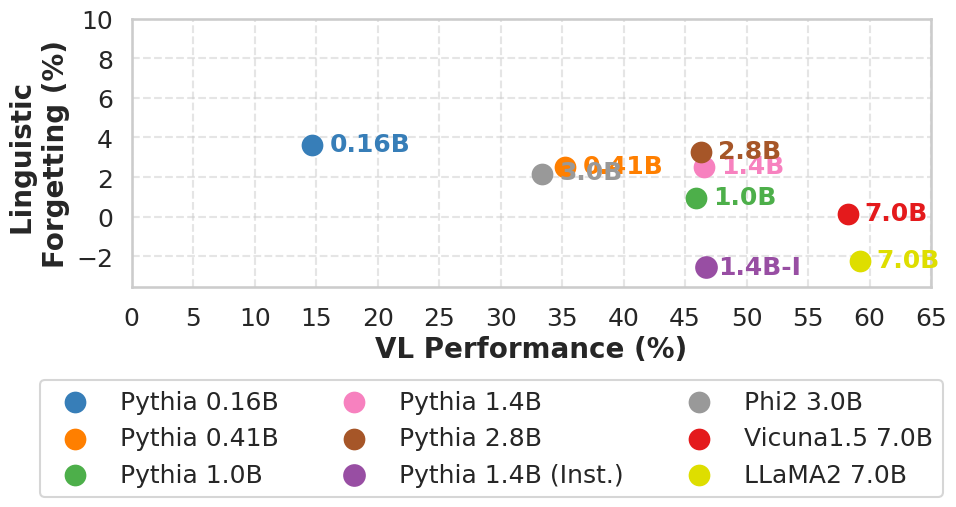

In [50]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

CB = ['#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
    '#999999', '#e41a1c', '#dede00']

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

plt.rcParams["figure.autolayout"] = True

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b",
            '1.4-instruct': "stage-final-llava-v15-pythia+1p4b-instruct"  # Pythia 1.4B Instruct
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b",
            '1.4-instruct': "reproduction-align-pythia+1p4b-instruct"  # Pythia 1.4B Instruct
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    },
    'LLaMA2': {
        'llava_original': {
            '7b': "reproduction-llama2"
        },
        'base_llm': {
            '7b': "vila_base_llm"
        }
    }
}

# Function to calculate NLP forgetting and VL performance using harmonic mean
def calculate_forgetting_and_performance(model_mappings, results):
    scores = []
    for model_type, mappings in model_mappings.items():
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                llava_nlp_scores = [results[llava_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
                base_nlp_scores = [results[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
                vl_scores = [results[llava_model].get(dataset, np.nan) * 100 for dataset in vl_datasets]
                
                valid_llava_nlp_scores = [score for score in llava_nlp_scores if not np.isnan(score)]
                valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
                valid_vl_scores = [score for score in vl_scores if not np.isnan(score)]
                
                if valid_llava_nlp_scores and valid_base_nlp_scores:
                    llava_hmean = np.mean(valid_llava_nlp_scores)
                    base_hmean = np.mean(valid_base_nlp_scores)
                    nlp_forgetting = base_hmean - llava_hmean
                else:
                    nlp_forgetting = np.nan
                
                avg_vl_performance = np.mean(valid_vl_scores) if valid_vl_scores else np.nan
                
                scores.append((model_type, scale, nlp_forgetting, avg_vl_performance))
    return scores

# Calculate forgetting and performance for each model type
scores = calculate_forgetting_and_performance(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for i in range(len(scores)):
    model_type, scale, nlp_forgetting, vl_performance = scores[i]
    if model_type in ['Phi2', 'Vicuna1.5', 'LLaMA2']:
        scale = scale_rename.get(scale, scale)
    scores[i] = (model_type, scale, nlp_forgetting, vl_performance)


# Plotting the scatter plot
#fig, ax = plt.subplots(figsize=(9, 5))
fig, ax = plt.subplots(figsize=(10, 6))

'''
for model_type, scale, nlp_forgetting, vl_performance in scores:
    ax.scatter(vl_performance, nlp_forgetting, label=f'{model_type} {scale}B', s=100)
    ax.text(vl_performance, nlp_forgetting, f'{scale}B', fontsize=12, ha='left')

ax.set_xlabel('VL Performance (%)')
ax.set_ylabel('Linguistic Forgetting (%)')
'''

m=20
p=18
i=0
for model_type, scale, nlp_forgetting, vl_performance in scores:

    if scale == '1.4-instruct':
        scale = '1.4'
        ax.scatter(vl_performance, nlp_forgetting, label=f'{model_type} {scale}B (Inst.)', s=220, color=CB[i])
        ax.text(vl_performance+7.7, nlp_forgetting-0.33, f'{scale}B-I', fontsize=p, ha='right', color=CB[i], fontweight='bold')
    else:
        ax.scatter(vl_performance, nlp_forgetting, label=f'{model_type} {scale}B', s=200, color=CB[i])
        if scale == 2.8:
            ax.text(vl_performance+6.5, nlp_forgetting-0.3, f'{scale}B', fontsize=p, ha='right', color=CB[i], fontweight='bold')
        #elif scale == 7:
        #    ax.text(vl_performance, nlp_forgetting+0.75, f'{scale}B', fontsize=p, ha='right')
        elif scale == 0.16 or scale == 0.41:
            ax.text(vl_performance+8, nlp_forgetting-0.3, f'{scale}B', fontsize=p, ha='right', color=CB[i], fontweight='bold')
        else:
            ax.text(vl_performance+6.5, nlp_forgetting-0.3, f'{scale}B', fontsize=p, ha='right', color=CB[i], fontweight='bold')
    i+=1

ax.set_xlabel('VL Performance (%)', fontsize=m, fontweight='bold')
ax.set_ylabel('Linguistic \nForgetting (%)', fontsize=m, fontweight='bold')

# Set the y-axis limits to start from -1 and depend on the data
y_min = min([score[2] for score in scores]) - 1
y_max = max([score[2] for score in scores]) + 1
ax.set_ylim(y_min, y_max)

ax.xaxis.set_ticks(np.arange(0, 66, step=5))
ax.yaxis.set_ticks(np.arange(-2, 11, step=2))

# Add the horizontal legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

ax.legend(by_label.values(), by_label.keys(), loc='upper center', 
  bbox_to_anchor=(0.45, -0.3), ncol=3, fontsize=m-2)

ax.tick_params(axis='both', which='major', width=2, length=10, labelsize=m-2)
ax.tick_params(axis='both', which='minor', width=2, length=10, labelsize=m-2)

plt.tight_layout()
plt.savefig('linguistic_forgetting_vs_vl_performance_scatter_latest.png', dpi=300)
plt.show()